# Intrusion Detection Data Generation with GAN

## Install Dependencies and prepare Train, Test Sets

In [26]:
!pip install ctgan
!pip install table_evaluator
!pip install numpy
!pip install gdown
!pip install sdv
!pip install nbformat --upgrade
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from table_evaluator import TableEvaluator
import sdv

In [17]:
train_data = pd.read_csv('KDDTrain.csv')

categorical_columns = [
    'protocol_type', 'service', 'flag', 'land', 'wrong_fragment', 'urgent',
    'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login', 
    'label'
]
print(train_data.dtypes)

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

## Train and Save GAN Model

In [19]:
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer
metadata = Metadata.detect_from_dataframe(
    data=train_data,
    table_name='nsl-kdd')

synthesizer = CTGANSynthesizer(
    metadata, # required
    enforce_rounding=False,
    epochs=500,
    verbose=True
)
synthesizer.get_parameters()

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


{'enforce_min_max_values': True,
 'enforce_rounding': False,
 'locales': ['en_US'],
 'embedding_dim': 128,
 'generator_dim': (256, 256),
 'discriminator_dim': (256, 256),
 'generator_lr': 0.0002,
 'generator_decay': 1e-06,
 'discriminator_lr': 0.0002,
 'discriminator_decay': 1e-06,
 'batch_size': 500,
 'discriminator_steps': 1,
 'log_frequency': True,
 'verbose': True,
 'epochs': 500,
 'pac': 10,
 'cuda': True}

In [20]:
synthesizer.fit(train_data)

Gen. (-0.80) | Discrim. (0.39): 100%|██████████| 500/500 [2:29:10<00:00, 17.90s/it]   


In [27]:
fig = synthesizer.get_loss_values_plot()
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [22]:
synthesizer.save(filepath='nsl-kdd.pkl')

## Load and Run Saved GAN Model

In [28]:
from sdv.single_table import CTGANSynthesizer

loaded_synthesizer = CTGANSynthesizer.load(filepath='nsl-kdd.pkl')

Note : In the below section we need to uncomment the timestamp conversion when creating dataset for training. 

In [29]:
# Generate synthetic data for the specific label 'u2r'
from sdv.sampling import Condition
condition =Condition(num_rows=250,column_values={'label': 'u2r'})

samples = loaded_synthesizer.sample_from_conditions(conditions=[condition])

# Print the generated samples
print(samples.head())

Sampling conditions: 100%|██████████| 250/250 [00:01<00:00, 215.23it/s]

   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        200      12494     0   
1         0           tcp  telnet   SF          0      22363     0   
2       204           tcp  telnet   SF       1780      11075     0   
3         0           tcp   login   SF          0      26113     0   
4        48           tcp  telnet   SF          0       2388     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                 164   
1               0       1    1  ...                   3   
2               0       0    2  ...                   2   
3               0       2    0  ...                   1   
4               0       0    3  ...                   1   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                0.999540                0.000000   
1                0.018267                0.025997   
2                0.999335                0.000066   
3           

(125973, 42) (22544, 42)


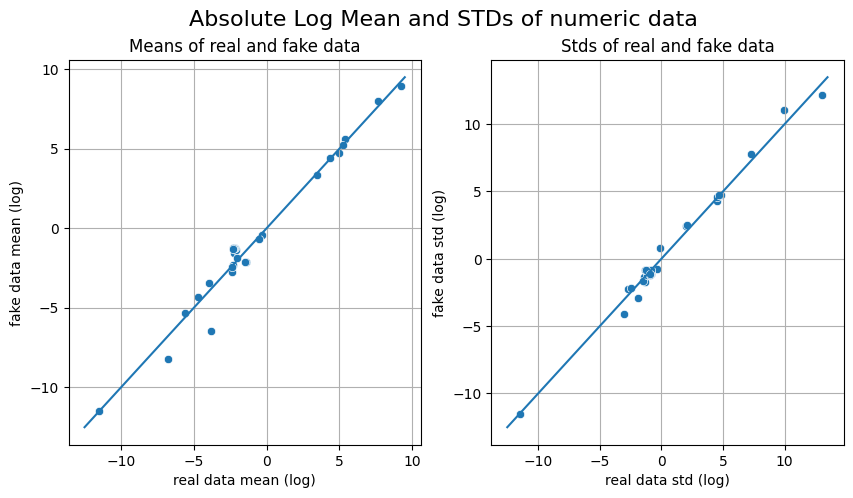

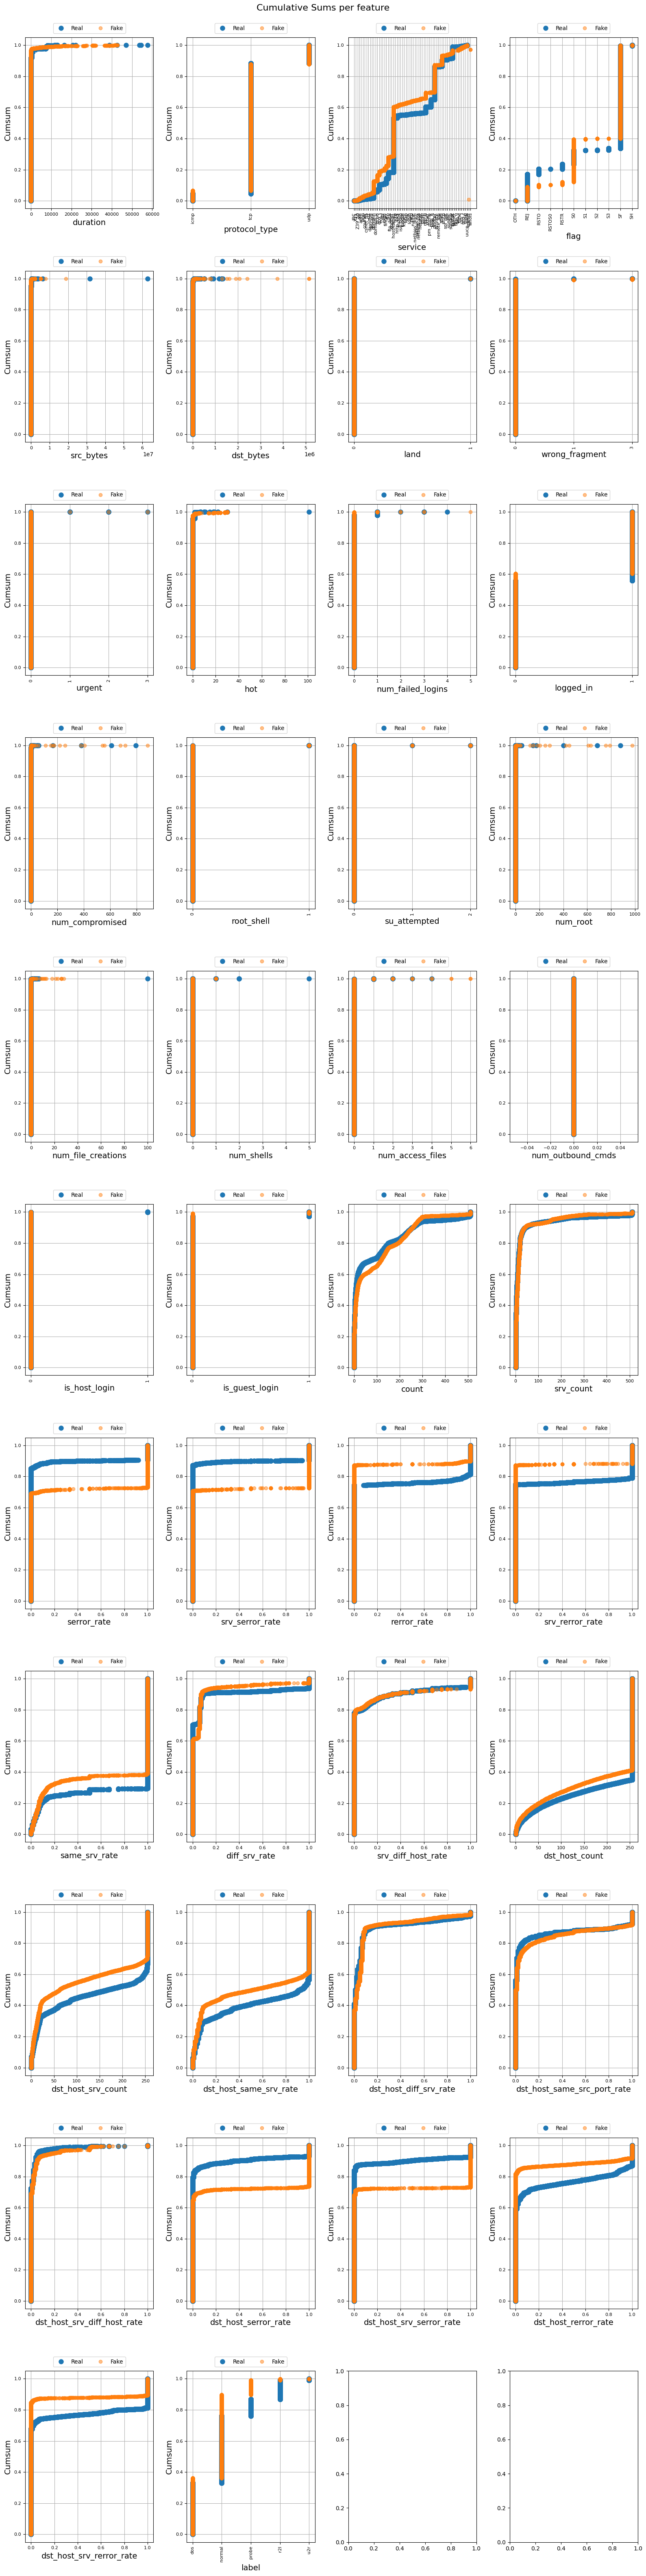

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

FixedFormatter should only be used together with FixedLocator



In [30]:
test_data = pd.read_csv('KDDTest.csv')
print(train_data.shape, test_data.shape)
#train_data['value'] = pd.to_numeric(test_data['value'], errors='coerce')
#test_data['timestamp'] = pd.to_datetime(test_data['timestamp'], unit='ms')
#test_data['timestamp'] = test_data['timestamp'].astype(int) / 10**9

table_evaluator =  TableEvaluator(test_data, train_data, cat_cols= categorical_columns)

table_evaluator.visual_evaluation()